In [1]:
import pandas as pd
from flask import Flask

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
# Data Import 데이터 불러오기
DataFile = pd.read_csv("MY2022 Fuel Consumption Ratings.csv")

In [4]:
# 데이터 분석했었던 것 읽어오기
DataFile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model Year                         946 non-null    int64  
 1   Make                               946 non-null    object 
 2   Model                              946 non-null    object 
 3   Vehicle Class                      946 non-null    object 
 4   Engine Size(L)                     946 non-null    float64
 5   Cylinders                          946 non-null    int64  
 6   Transmission                       946 non-null    object 
 7   Fuel Type                          946 non-null    object 
 8   Fuel Consumption (City (L/100 km)  946 non-null    float64
 9   Fuel Consumption(Hwy (L/100 km))   946 non-null    float64
 10  Fuel Consumption(Comb (L/100 km))  946 non-null    float64
 11  Fuel Consumption(Comb (mpg))       946 non-null    int64  

In [5]:
# column들 보기
DataFile.columns

Index(['Model Year', 'Make', 'Model', 'Vehicle Class', 'Engine Size(L)',
       'Cylinders', 'Transmission', 'Fuel Type',
       'Fuel Consumption (City (L/100 km)', 'Fuel Consumption(Hwy (L/100 km))',
       'Fuel Consumption(Comb (L/100 km))', 'Fuel Consumption(Comb (mpg))',
       'CO2 Emissions(g/km)', 'CO2 Rating', 'Smog Rating'],
      dtype='object')

In [6]:
# 중요한 변수 3가지만 일단 선택 (API 서비스를 위한)
DataFile.columns[[5, 10, 13]]

Index(['Cylinders', 'Fuel Consumption(Comb (L/100 km))', 'CO2 Rating'], dtype='object')

In [7]:
# 데이터 선택 및 X, Y 데이터 선정
Data = DataFile[DataFile.columns[[5, 10, 13]]]
Label = DataFile['CO2 Emissions(g/km)']

In [8]:
# Train / Valid 나누기
TrainX = Data.iloc[:-200,:]
TrainY = Label[:-200]

ValidX = Data.iloc[-200:,:]
ValidY = Label[-200:]

In [14]:
TrainX

,Cylinders,Fuel Consumption(Comb (L/100 km)),CO2 Rating
0,4,8.6,6
1,6,11.2,4
2,4,9.9,5
3,4,10.3,5
4,4,9.8,5
...,...,...,...
741,4,7.3,7
742,4,7.9,6
743,4,8.1,6
744,4,6.7,7


In [9]:
# 모델 구조
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(3,)))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='linear'))

# CallBack 함수를 통해 LR을 낮출 것이므로, 초기 LR을 높게 잡기
model.compile(loss='mse',
              optimizer='Adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
#0.001

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 30)                270       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 333
Trainable params: 333
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model 저장할 폴더 위치 선정
os.makedirs('Model', exist_ok=True)

In [12]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='Model/{epoch:03d}-{loss:.4f}-{val_loss:.4f}.hdf5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#minitor -> loss -> val_loss

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=5,
                       verbose=1, min_lr=1e-8)
# factor: Learning rate에 곱할 것.
#0.1 -> 0.08 -> 0.064 ....
#monitor='loss' -> monitor='val_loss'

CALLBACK = [CP, LR]

In [13]:
model.fit(x=TrainX, y=TrainY, epochs=800, shuffle=True,
          batch_size=48, callbacks=CALLBACK, validation_data = (ValidX, ValidY))

Epoch 1/800
 1/16 [>.............................] - ETA: 4s - loss: 74077.8359 - root_mean_squared_error: 272.1724
Epoch 1: val_loss improved from inf to 64709.50391, saving model to Model\001-71016.4141-64709.5039.hdf5
16/16 [==============================] - 0s 8ms/step - loss: 71016.4141 - root_mean_squared_error: 266.4891 - val_loss: 64709.5039 - val_root_mean_squared_error: 254.3806 - lr: 0.0010
Epoch 2/800
 1/16 [>.............................] - ETA: 0s - loss: 65081.9062 - root_mean_squared_error: 255.1116
Epoch 2: val_loss improved from 64709.50391 to 63228.64844, saving model to Model\002-69510.8906-63228.6484.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 69510.8906 - root_mean_squared_error: 263.6492 - val_loss: 63228.6484 - val_root_mean_squared_error: 251.4531 - lr: 0.0010
Epoch 3/800
 1/16 [>.............................] - ETA: 0s - loss: 72461.8516 - root_mean_squared_error: 269.1874
Epoch 3: val_loss improved from 63228.64844 to 61372.71875, saving

In [15]:
Pred = model.predict(ValidX)

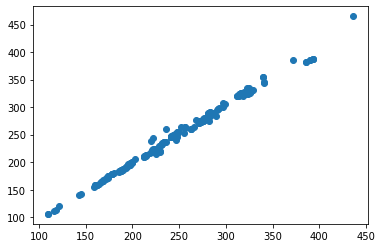

In [16]:
plt.plot(Pred, ValidY, 'o')
plt.show()

In [ ]:
app = Flask(__name__)

@app.route("/")
def hello_world():
    return "<p>Hello, World!</p>" 

In [ ]:
@app.route("/sosal")
def hello_sosal():
    return "<p>Hello, sosal</p>" 

In [ ]:
app.run(host='127.0.0.1', port=5000)